# Exploración de datos y preparación (Capa Plata)

En esta clase trabajaremos con los datos meteorológicos previamente filtrados por estación (Capa Bronce) para realizar una primera exploración estructurada. El objetivo es transformar los datos crudos en un conjunto limpio, validado y enriquecido, listo para su análisis.

## Objetivos de la clase:
- Identificar tipos de análisis exploratorio.
- Aplicar transformaciones básicas en la Capa Plata.
- Detectar y tratar valores nulos y atípicos.
- Generar estadísticas descriptivas por estación y fecha.
- Visualizar las principales variables meteorológicas.
- Exportar el dataset en múltiples formatos para su posterior análisis.

El foco estará puesto en la limpieza, validación, estandarización y normalización de datos para facilitar su consumo en dashboards, análisis y modelos posteriores.


## Importación de librerías y configuración de paths

In [11]:
# Importar librerías necesarias
import os
from datetime import date
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
from windrose import WindroseAxes
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Definir rutas para capas Bronce y Plata y Diccionario
BRONCE_DIR = Path('../data/bronce/')
PLATA_DIR = Path('../data/plata/')
PLATA_DIR.mkdir(parents=True, exist_ok=True)
# Crear carpeta para faltantes si no existe
FALTANTES_DIR = Path('../data/faltantes/')
FALTANTES_DIR.mkdir(parents=True, exist_ok=True)
# Crear carpeta para guardar los metadatos
DICCIONARIO_DIR = Path('../data/diccionario/')
DICCIONARIO_DIR.mkdir(parents=True, exist_ok=True)

# Variable de la provincia para generar los metadatos
PROVINCIA = 'ENTRE RIOS'

# Ajustar el ancho máximo para impresión en consola
pd.set_option('display.max_columns', None)  # Mostrar todas las columnas
pd.set_option('display.width', 300)         # Ajustar a un ancho suficiente en consola
pd.set_option('display.max_colwidth', None) # Evitar recortes en contenido de celdas

print("Importación de librerías completada.")

Importación de librerías completada.


## Carga de archivos de todas las estaciones de la provincia seleccionada

In [12]:
# Cargar todos los archivos CSV de la capa Bronce (filtrados por estaciones)
archivos = list(BRONCE_DIR.rglob("*.csv"))
dfs = []

for archivo in archivos:
    try:
        #print(archivo)
        df = pd.read_csv(archivo)
        df['estacion_archivo'] = archivo.stem  # Agregar nombre del archivo como identificador de estación
        dfs.append(df)
    except Exception as e:
        print(f"Error leyendo {archivo}: {e}")

# Concatenar todos los DataFrames en uno solo
df_estaciones = pd.concat(dfs, ignore_index=True)
print(df_estaciones)

      FECHA  HORA  TEMP  HUM     PNM   DD  FF          NOMBRE         estacion_archivo
0   1062024     0  16.0   81  1016.5   50  20  CONCORDIA AERO  20240601_concordia_aero
1   1062024     1  15.2   87  1016.2   30  17  CONCORDIA AERO  20240601_concordia_aero
2   1062024     2  15.2   87  1016.2   30  17  CONCORDIA AERO  20240601_concordia_aero
3   1062024     3  15.0   87  1015.6   20  17  CONCORDIA AERO  20240601_concordia_aero
4   1062024     4  15.0   89  1015.4   30  15  CONCORDIA AERO  20240601_concordia_aero
..      ...   ...   ...  ...     ...  ...  ..             ...                      ...
59  1062024    19  19.7   70  1011.8   90   6     PARANA AERO     20240601_parana_aero
60  1062024    20  18.0   82  1012.0  360   4     PARANA AERO     20240601_parana_aero
61  1062024    21  17.5   86  1012.4  330   6     PARANA AERO     20240601_parana_aero
62  1062024    22  16.5   90  1012.5  360   4     PARANA AERO     20240601_parana_aero
63  1062024    23  15.1   93  1012.4  120  

## Normalización y combinación de fecha y hora

In [13]:
# Convertir FECHA (DDMMAAAA) a string y formatear como DDMMAAAA
df_estaciones['FECHA'] = df_estaciones['FECHA'].astype(str).str.zfill(8)

# Convertir a formato datetime (indicando el formato original)
df_estaciones['FECHA'] = pd.to_datetime(df_estaciones['FECHA'], format='%d%m%Y', errors='coerce')

# Asegurar que HORA está en número entero (algunos datasets los tienen como string)
df_estaciones['HORA'] = df_estaciones['HORA'].astype(int)

# Crear columna combinada FECHA_HORA como datetime completo
df_estaciones['FECHA_HORA'] = df_estaciones['FECHA'] + pd.to_timedelta(df_estaciones['HORA'], unit='h')

# Verificamos el resultado
print(df_estaciones[['FECHA', 'HORA', 'FECHA_HORA']].head())

       FECHA  HORA          FECHA_HORA
0 2024-06-01     0 2024-06-01 00:00:00
1 2024-06-01     1 2024-06-01 01:00:00
2 2024-06-01     2 2024-06-01 02:00:00
3 2024-06-01     3 2024-06-01 03:00:00
4 2024-06-01     4 2024-06-01 04:00:00


## Guardar el archivo con los datos horarios de las estaciones de la provincia

In [14]:
archivo_horario = PLATA_DIR / "horario_archivo.csv"

# Guardar el archivo con datos horarios
df_estaciones.to_csv(archivo_horario, index=False)

print(f"Archivo horario exportado correctamente a:\n{archivo_horario}")
print(f"Filas: {len(df_estaciones)} – Columnas: {len(df_estaciones.columns)}")
print("\nVista previa de datos horarios:")
print(df_estaciones.head(3))

Archivo horario exportado correctamente a:
../data/plata/horario_archivo.csv
Filas: 64 – Columnas: 10

Vista previa de datos horarios:
       FECHA  HORA  TEMP  HUM     PNM  DD  FF          NOMBRE         estacion_archivo          FECHA_HORA
0 2024-06-01     0  16.0   81  1016.5  50  20  CONCORDIA AERO  20240601_concordia_aero 2024-06-01 00:00:00
1 2024-06-01     1  15.2   87  1016.2  30  17  CONCORDIA AERO  20240601_concordia_aero 2024-06-01 01:00:00
2 2024-06-01     2  15.2   87  1016.2  30  17  CONCORDIA AERO  20240601_concordia_aero 2024-06-01 02:00:00


### Agrupación diaria de variables por estación

En esta sección agrupamos los datos meteorológicos por estación y por fecha. 
Calculamos estadísticas clave como temperatura, presión, humedad, dirección y velocidad del viento. 
Esto permite obtener un resumen diario limpio para cada estación, facilitando su análisis posterior.

In [15]:
# Agrupar por estación y fecha para obtener valores resumen diarios
df_estaciones_group = df_estaciones.groupby(['NOMBRE', 'FECHA']).agg({
    'TEMP': ['mean', 'min', 'max'],
    'PNM': ['mean', 'min', 'max'],
    'HUM': ['mean', 'min', 'max'],
    'DD': 'mean',
    'FF': 'mean'
}).reset_index()

# Renombrar columnas para facilitar su uso
df_estaciones_group.columns = ['ESTACION', 'FECHA',
                               'TEMP_MEAN', 'TEMP_MIN', 'TEMP_MAX',
                               'PNM_MEAN', 'PNM_MIN', 'PNM_MAX',
                               'HUM_MEAN', 'HUM_MIN', 'HUM_MAX',
                               'WIND_DIR_MEAN', 'WIND_SPEED_MEAN']

print(df_estaciones_group)

            ESTACION      FECHA  TEMP_MEAN  TEMP_MIN  TEMP_MAX     PNM_MEAN  PNM_MIN  PNM_MAX   HUM_MEAN  HUM_MIN  HUM_MAX  WIND_DIR_MEAN  WIND_SPEED_MEAN
0     CONCORDIA AERO 2024-06-01  17.479167      14.6      22.4  1015.004167   1013.3   1016.5  82.750000       66       93      50.416667        12.000000
1  GUALEGUAYCHU AERO 2024-06-01  18.850000      14.0      24.7  1013.331250   1011.6   1014.9  76.937500       56       94     183.750000        10.500000
2        PARANA AERO 2024-06-01  17.400000      13.2      23.7  1013.004167   1011.2   1014.8  80.458333       57       97     222.500000         6.958333


## Validación estructural: detección de duplicados

Antes de avanzar con el análisis, verificamos si existen filas duplicadas por combinación de estación y fecha, lo cual indicaría problemas en la agregación de datos.

In [16]:
duplicados = df_estaciones_group.duplicated(subset=['ESTACION', 'FECHA']).sum()
print(f" Duplicados por estación y fecha: {duplicados}")

 Duplicados por estación y fecha: 0


## Análisis de cobertura temporal por estación

In [17]:
# Crear rango completo de fechas
rango_fechas = pd.date_range(df_estaciones_group['FECHA'].min(), df_estaciones_group['FECHA'].max())

# Detectar días faltantes por estación y exportar
for estacion in df_estaciones_group['ESTACION'].unique():
    fechas_est = pd.to_datetime(df_estaciones_group[df_estaciones_group['ESTACION'] == estacion]['FECHA'].unique())
    dias_faltantes = sorted(set(rango_fechas) - set(fechas_est))

    # Crear archivo por estación
    nombre_archivo = FALTANTES_DIR / f'dias_faltantes_{estacion.replace(" ", "_").lower()}.txt'
    with open(nombre_archivo, 'w', encoding='utf-8') as f:
        f.write(f"Días faltantes para estación: {estacion}\n")
        f.write(f"Total: {len(dias_faltantes)}\n\n")
        for dia in dias_faltantes:
            f.write(f"{dia.strftime('%Y-%m-%d')}\n")

    # Mostrar resumen por consola
    print(f" Estación: {estacion}")
    print(f" Días faltantes: {len(dias_faltantes)}")
    print(f" Archivo: {nombre_archivo.name}\n")

 Estación: CONCORDIA AERO
 Días faltantes: 0
 Archivo: dias_faltantes_concordia_aero.txt

 Estación: GUALEGUAYCHU AERO
 Días faltantes: 0
 Archivo: dias_faltantes_gualeguaychu_aero.txt

 Estación: PARANA AERO
 Días faltantes: 0
 Archivo: dias_faltantes_parana_aero.txt



## Exploración univariada de variables meteorológicas

A continuación, se presentan histogramas para explorar la distribución de variables meteorológicas clave. Esto permite identificar posibles sesgos, valores extremos o asimetrías en la distribución de cada variable.

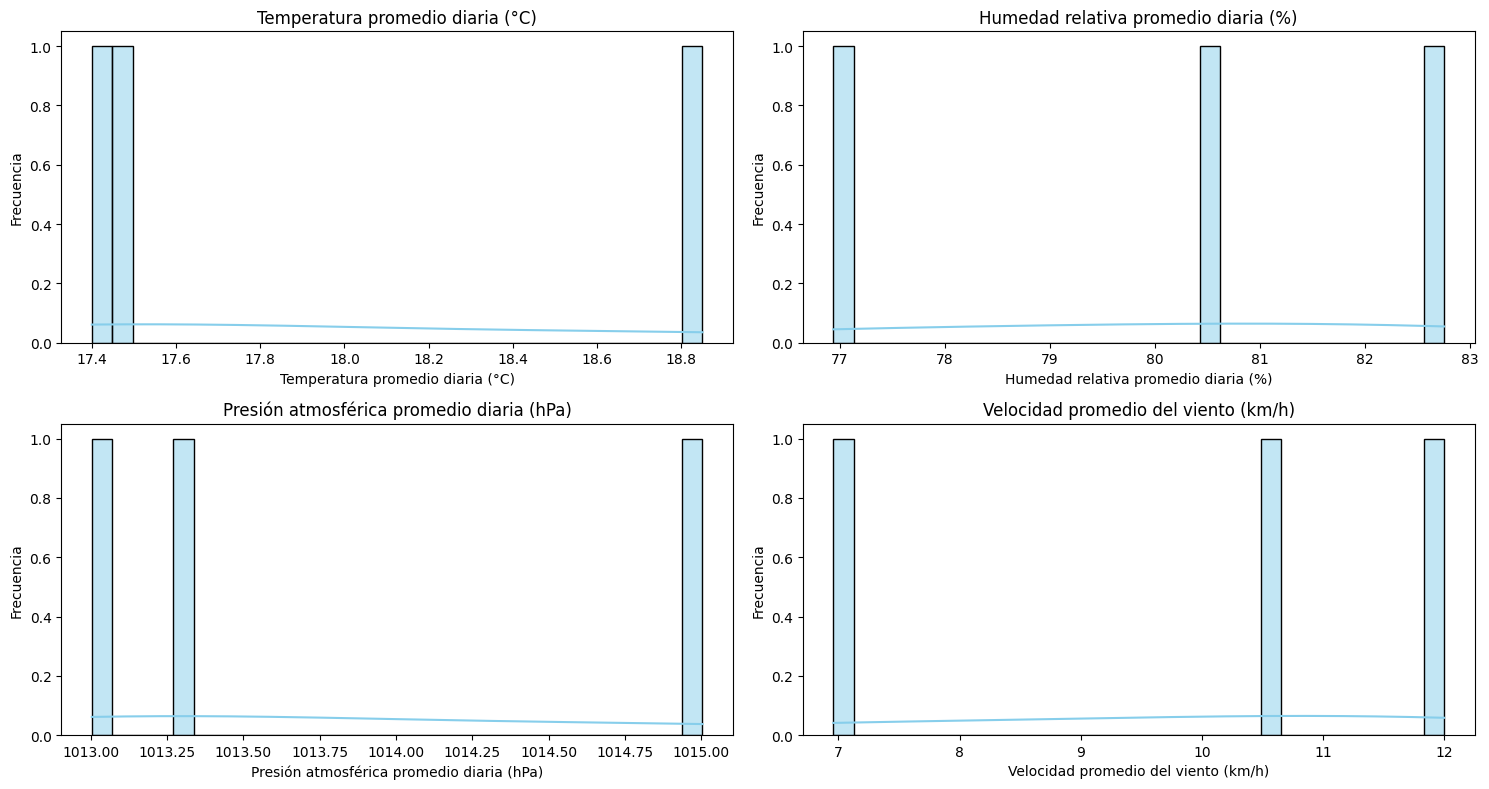

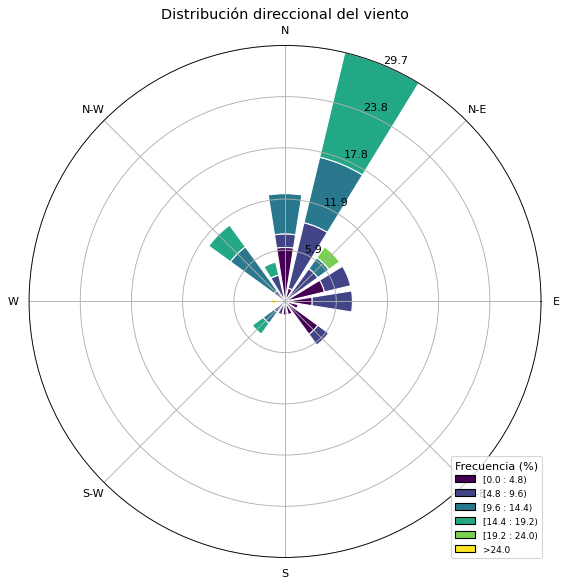

In [18]:
# Variables a graficar
variables_hist = {
    'TEMP_MEAN': 'Temperatura promedio diaria (°C)',
    'HUM_MEAN': 'Humedad relativa promedio diaria (%)',
    'PNM_MEAN': 'Presión atmosférica promedio diaria (hPa)',
    'WIND_SPEED_MEAN': 'Velocidad promedio del viento (km/h)'
}

# Crear subplots para los histogramas
plt.figure(figsize=(15, 8))
for i, (var, titulo) in enumerate(variables_hist.items(), 1):
    plt.subplot(2, 2, i)
    sns.histplot(df_estaciones_group[var], kde=True, bins=30, color='skyblue')
    plt.title(titulo, fontsize=12)
    plt.xlabel(titulo)
    plt.ylabel('Frecuencia')

plt.tight_layout()
plt.show()

# Crear gráfico Windrose para WIND_DIR_MEAN
df_viento = df_estaciones[(df_estaciones['DD'] <= 360)]

ax = WindroseAxes.from_ax()
ax.bar(df_viento['DD'], df_viento['FF'], normed=True, opening=0.8, edgecolor='white')

# Ajustes de visualización
ax.set_title("Distribución direccional del viento", fontsize=13)
ax.set_legend(loc='lower right', title="Frecuencia (%)", fontsize=9, title_fontsize=10, frameon=True)
plt.show()

## Análisis exploratorio – valores máximos, mínimos, promedio diario

In [19]:
# Verificar valores inválidos en DD (mayores a 360)
valores_dd_invalidos = df_estaciones[df_estaciones['DD'] > 360]['DD'].unique()
print("Valores inválidos en DD (mayores a 360):", valores_dd_invalidos, "\n")

# Crear columna de fecha sin hora para agrupar
df_estaciones['FECHA_DIA'] = df_estaciones['FECHA'].dt.date

# Crear DD_VALID con NaN en valores > 360 (para excluir del promedio)
df_estaciones['DD_VALID'] = df_estaciones['DD'].where(df_estaciones['DD'] <= 360, pd.NA)

# Paso 3: Agrupar por estación y día, y calcular estadísticas
df_estaciones_group = df_estaciones.groupby(['NOMBRE', 'FECHA_DIA']).agg({
    'TEMP': ['mean', 'min', 'max'],
    'PNM': ['mean', 'min', 'max'],
    'HUM': ['mean', 'min', 'max'],
    'DD_VALID': ['mean'],       # Promedio con valores válidos solamente
    'DD': ['min', 'max'],       # Para conservar min y max sin filtrar
    'FF': ['mean', 'min', 'max']
}).reset_index()

# Renombrar columnas para facilitar lectura
df_estaciones_group.columns = [
    'ESTACION', 'FECHA',
    'TEMP_MEAN', 'TEMP_MIN', 'TEMP_MAX',
    'PNM_MEAN', 'PNM_MIN', 'PNM_MAX',
    'HUM_MEAN', 'HUM_MIN', 'HUM_MAX',
    'WIND_DIR_MEAN',  # <- Esta es la media con valores válidos
    'WIND_DIR_MIN', 'WIND_DIR_MAX',
    'WIND_SPEED_MEAN', 'WIND_SPEED_MIN', 'WIND_SPEED_MAX'
]

# Redondear solo las columnas *_MEAN a 1 decimal
cols_mean = ['TEMP_MEAN', 'PNM_MEAN', 'HUM_MEAN', 'WIND_DIR_MEAN', 'WIND_SPEED_MEAN']
df_estaciones_group[cols_mean] = df_estaciones_group[cols_mean].round(1)

# Vista previa
print(df_estaciones_group)


Valores inválidos en DD (mayores a 360): [] 

            ESTACION       FECHA  TEMP_MEAN  TEMP_MIN  TEMP_MAX  PNM_MEAN  PNM_MIN  PNM_MAX  HUM_MEAN  HUM_MIN  HUM_MAX  WIND_DIR_MEAN  WIND_DIR_MIN  WIND_DIR_MAX  WIND_SPEED_MEAN  WIND_SPEED_MIN  WIND_SPEED_MAX
0     CONCORDIA AERO  2024-06-01       17.5      14.6      22.4    1015.0   1013.3   1016.5      82.8       66       93           50.4            20           360             12.0               4              20
1  GUALEGUAYCHU AERO  2024-06-01       18.8      14.0      24.7    1013.3   1011.6   1014.9      76.9       56       94          183.8            20           360             10.5               4              24
2        PARANA AERO  2024-06-01       17.4      13.2      23.7    1013.0   1011.2   1014.8      80.5       57       97          222.5             0           360              7.0               0              17


## Visualización por estación y por variable

Se generan gráficos individuales para cada estación meteorológica, mostrando la evolución diaria de temperatura, presión, humedad y viento. 
También se incluye una visualización tipo Windrose para observar la distribución de la dirección y velocidad del viento.


 Estación: CONCORDIA AERO


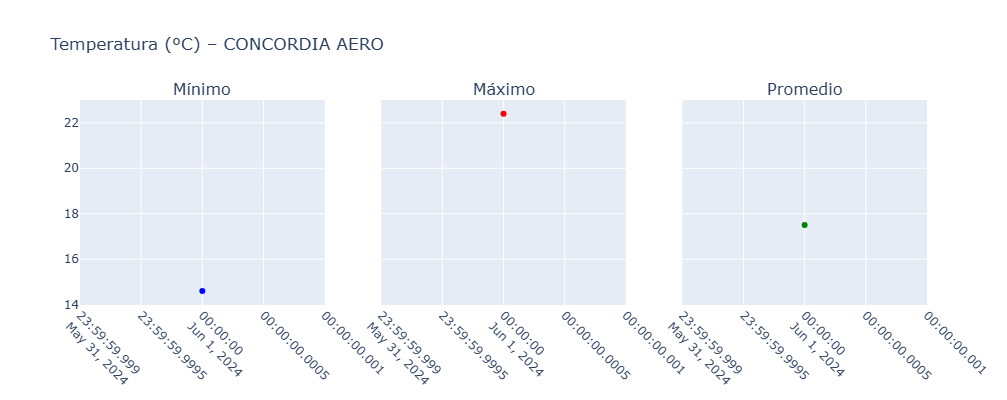

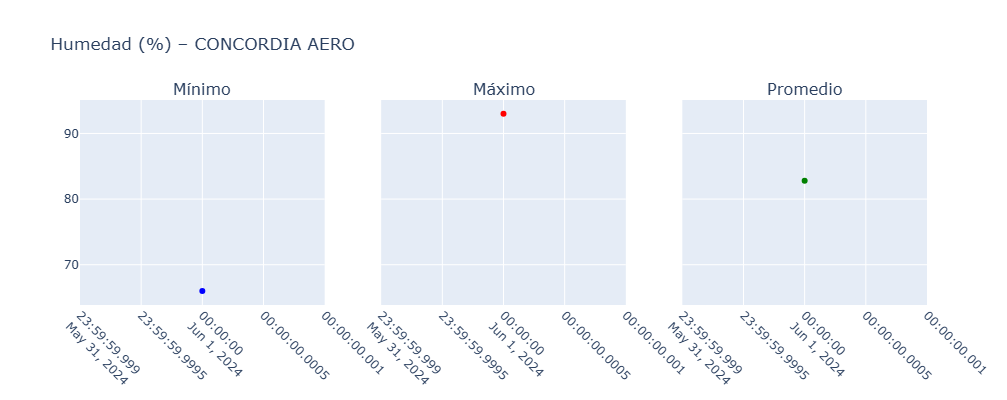

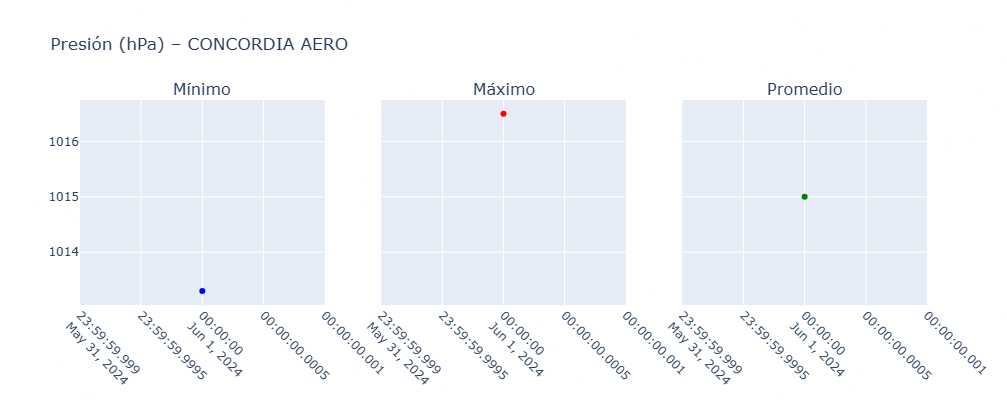

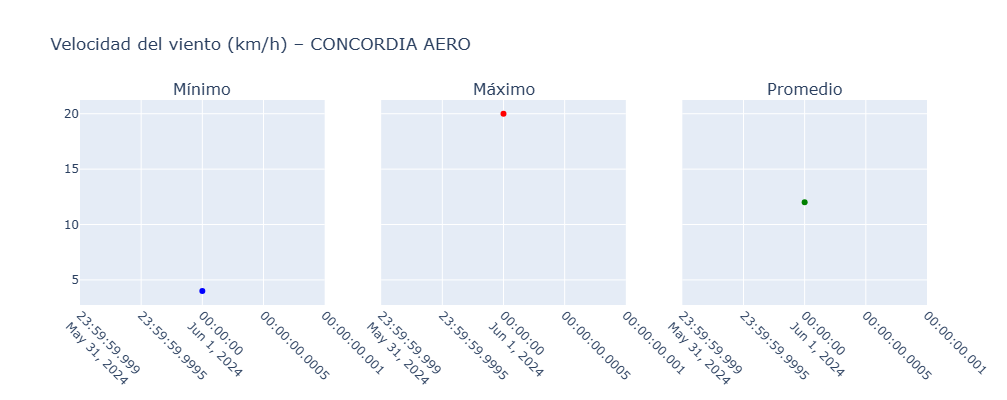

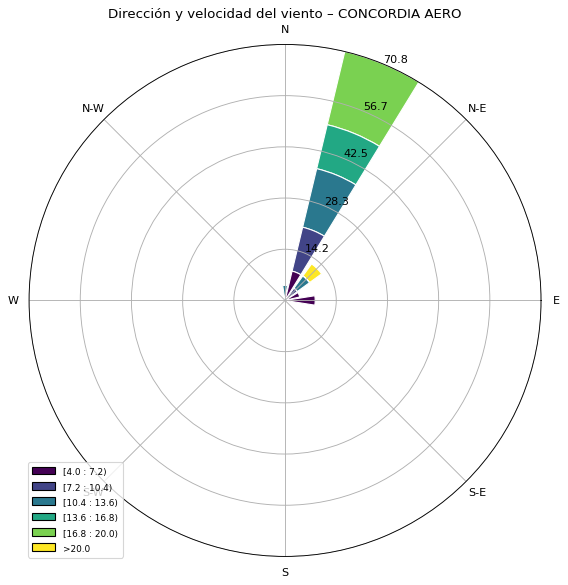


 Estación: GUALEGUAYCHU AERO


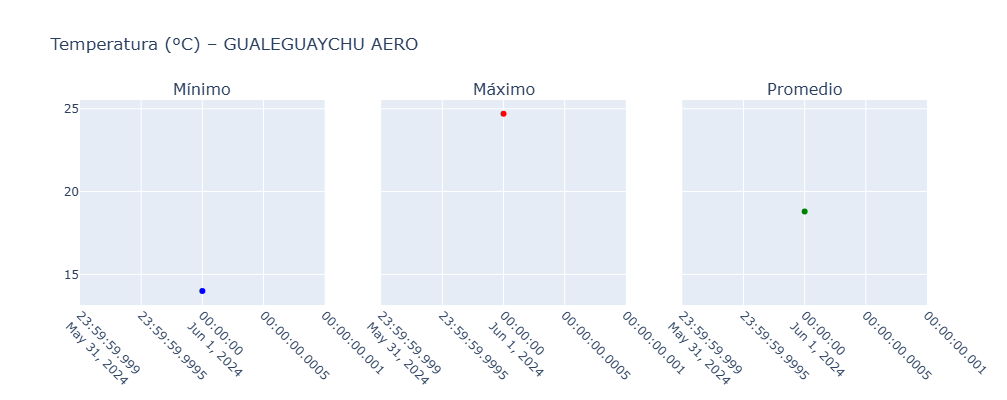

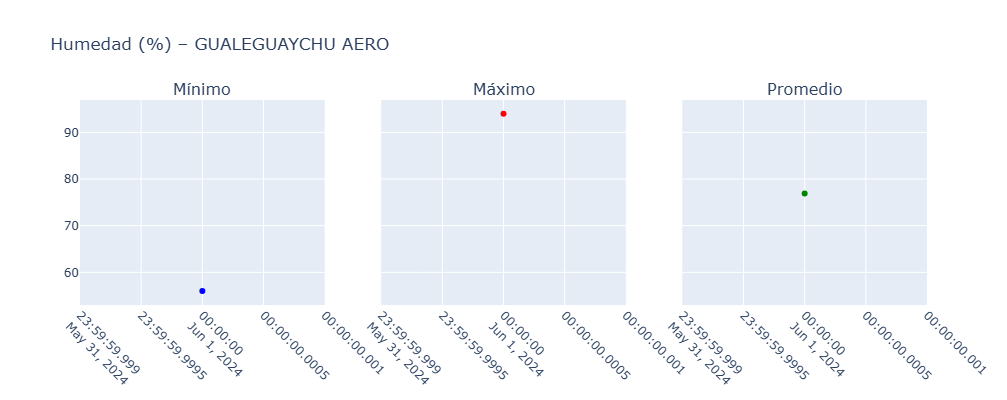

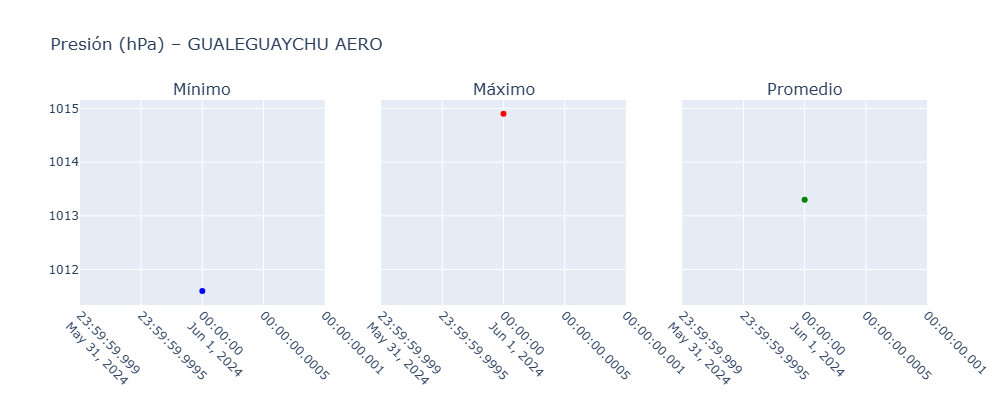

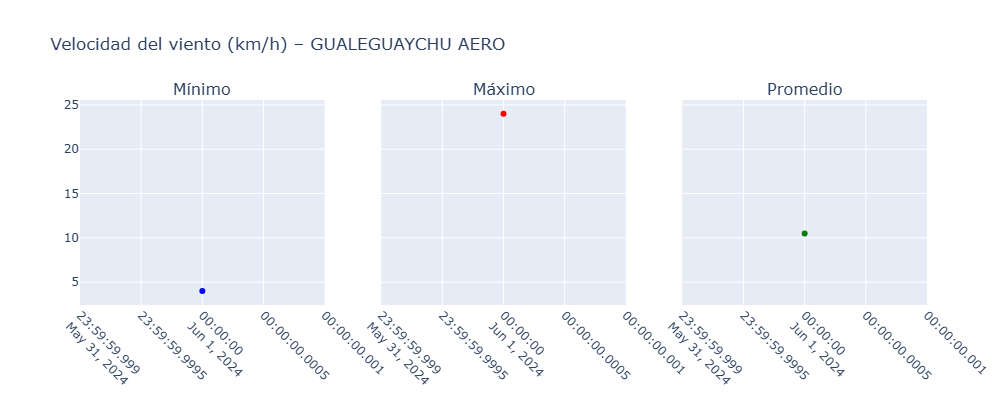

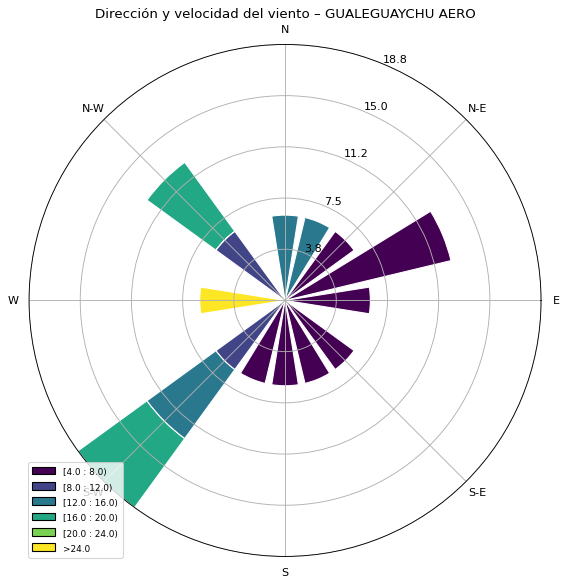


 Estación: PARANA AERO


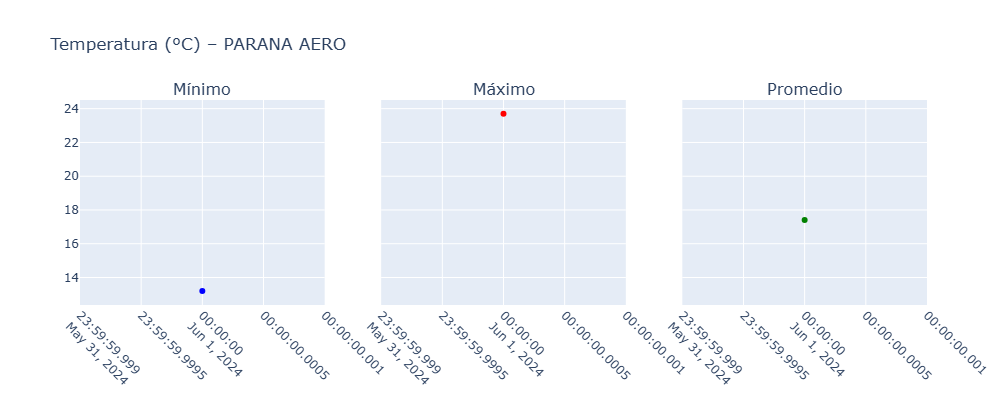

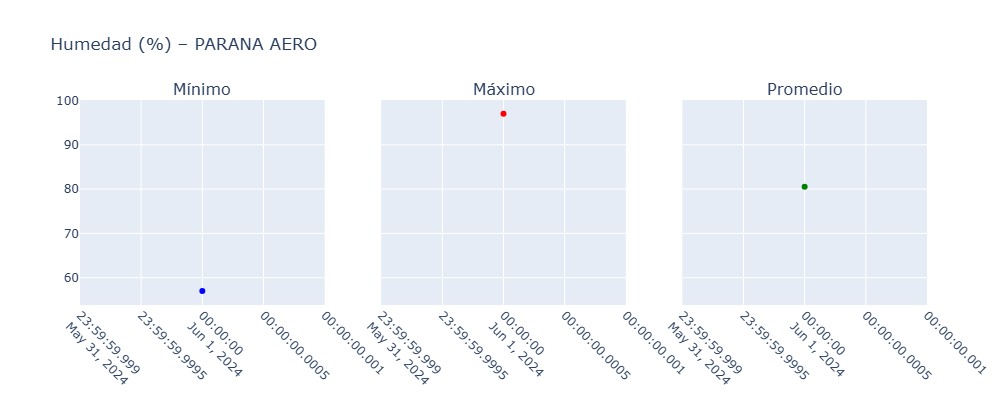

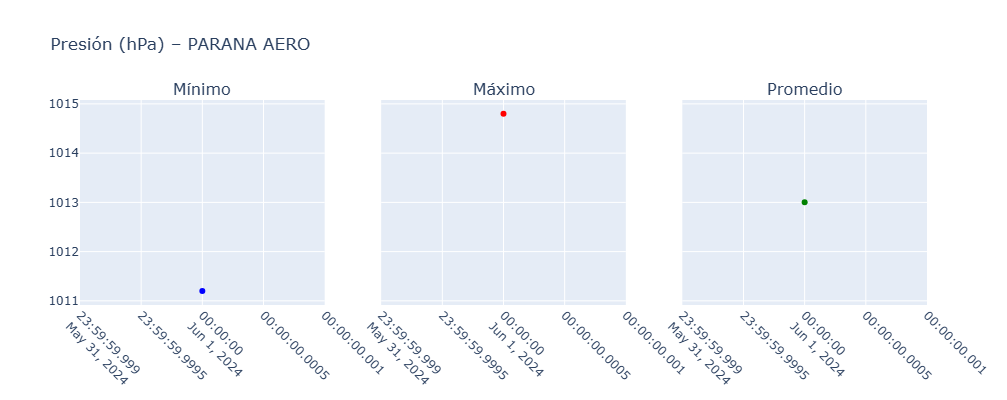

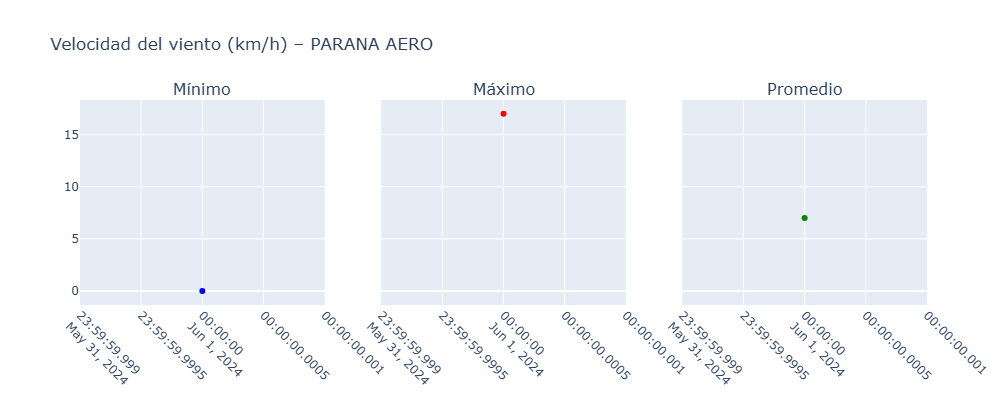

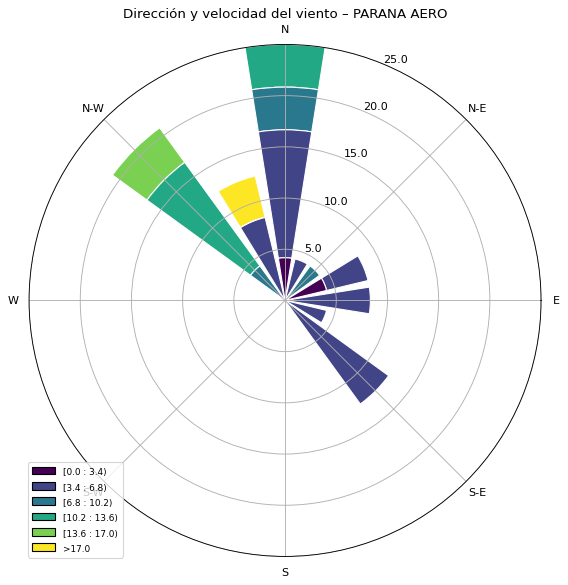

In [20]:
# Asegurar que FECHA esté en datetime
df_estaciones_group['FECHA'] = pd.to_datetime(df_estaciones_group['FECHA'])

variables = {
    'TEMP': {'min': 'TEMP_MIN', 'mean': 'TEMP_MEAN', 'max': 'TEMP_MAX', 'label': 'Temperatura (°C)'},
    'HUM': {'min': 'HUM_MIN', 'mean': 'HUM_MEAN', 'max': 'HUM_MAX', 'label': 'Humedad (%)'},
    'PNM': {'min': 'PNM_MIN', 'mean': 'PNM_MEAN', 'max': 'PNM_MAX', 'label': 'Presión (hPa)'},
    'WIND_SPEED': {'min': 'WIND_SPEED_MIN', 'mean': 'WIND_SPEED_MEAN', 'max': 'WIND_SPEED_MAX', 'label': 'Velocidad del viento (km/h)'}
}

# Recorrer estaciones
for estacion in df_estaciones_group['ESTACION'].unique():
    df_est_group = df_estaciones_group[df_estaciones_group['ESTACION'] == estacion]
    df_est_raw = df_estaciones[(df_estaciones['NOMBRE'] == estacion) & (df_estaciones['DD'] <= 360)]

    print(f"\n Estación: {estacion}")

    # Una fila por variable (cada una con 3 columnas: min, mean, max)
    for var, datos in variables.items():
        fig = make_subplots(
            rows=1, cols=3,
            shared_yaxes=True,
            subplot_titles=("Mínimo", "Máximo", "Promedio")
        )

        colores = {
            'min': 'blue',
            'max': 'red',
            'mean': 'green'
        }
        
        for i, tipo in enumerate(['min', 'max', 'mean']):
            fig.add_trace(
                go.Scatter(
                    x=df_est_group['FECHA'],
                    y=df_est_group[datos[tipo]],
                    mode='lines+markers',
                    name=f"{datos['label']} – {tipo}",
                    line=dict(color=colores[tipo]),
                    hovertemplate="Fecha: %{x|%d-%m-%Y}<br>Valor: %{y:.2f}<extra></extra>"
                ),
                row=1, col=i + 1
            )

        fig.update_layout(
            title_text=f"{datos['label']} – {estacion}",
            height=400,
            showlegend=False
        )
        fig.update_xaxes(tickangle=45)
        fig.show()

    # Graficar rosa del viento con matplotlib (se mantiene igual)
    ax = WindroseAxes.from_ax()
    ax.bar(df_est_raw['DD'], df_est_raw['FF'], normed=True, opening=0.8, edgecolor='white')
    ax.set_title(f'Dirección y velocidad del viento – {estacion}', fontsize=12)
    ax.set_legend()
    plt.show()


## Normalización Min-Max: ¿Por qué la aplicamos?

Cuando trabajamos con múltiples variables meteorológicas —como temperatura, presión, humedad, dirección y velocidad del viento— nos enfrentamos a un problema: **cada una está en una escala diferente**.

- Temperatura: 5 °C a 35 °C  
- Presión atmosférica: 1000 a 1030 hPa  
- Humedad relativa: 40 % a 100 %  
- Dirección del viento: 0° a 360°  
- Velocidad del viento: 0 a 30 km/h  

Estas diferencias pueden dificultar tanto la comparación visual como el análisis conjunto. Para resolverlo, aplicamos la **normalización Min-Max**, que transforma cada valor al rango [0, 1] manteniendo su proporcionalidad, mediante la siguiente fórmula:

$$
x_{\text{norm}} = \frac{x - x_{\text{min}}}{x_{\text{max}} - x_{\text{min}}}
$$

Donde:  
- $x$ es el valor original  
- $x_{\text{min}}$ es el mínimo observado de la variable  
- $x_{\text{max}}$ es el máximo observado de la variable  

### ¿Qué logramos con esto?

- Facilitar la **comparación visual** entre variables heterogéneas  
- Preparar los datos para **análisis multivariado** (como clustering o reducción de dimensiones)  
- Evitar que variables con mayor escala **dominen** sobre otras en modelos o gráficos  
- Posibilitar visualizaciones integradas, como **gráficos radar o líneas normalizadas**

> Esta transformación no modifica la forma de la distribución, sino únicamente su escala, lo que permite trabajar todas las variables en igualdad de condiciones.


In [21]:
# Verificar cantidad de valores nulos antes del rellenado
print("🔍 Valores nulos por columna antes del forward fill:\n")
print(df_estaciones_group.isnull().sum())

# Rellenar valores nulos con forward fill
df_estaciones_group.ffill(inplace=True)

# Definir columnas *_MEAN para normalizar
cols_mean = ['TEMP_MEAN', 'PNM_MEAN', 'HUM_MEAN', 'WIND_DIR_MEAN', 'WIND_SPEED_MEAN']

# Aplicar normalización Min-Max y mostrar ejemplos
for col in cols_mean:
    min_val = df_estaciones_group[col].min()
    max_val = df_estaciones_group[col].max()
    df_estaciones_group[col + '_NORM'] = (df_estaciones_group[col] - min_val) / (max_val - min_val)
    
    # Imprimir resumen
    print(f"\n🔹 Normalización de {col}:")
    print(f"   Valor mínimo: {min_val:.2f}, máximo: {max_val:.2f}")
    print(df_estaciones_group[[col, col + '_NORM']].head(5))

🔍 Valores nulos por columna antes del forward fill:

ESTACION           0
FECHA              0
TEMP_MEAN          0
TEMP_MIN           0
TEMP_MAX           0
PNM_MEAN           0
PNM_MIN            0
PNM_MAX            0
HUM_MEAN           0
HUM_MIN            0
HUM_MAX            0
WIND_DIR_MEAN      0
WIND_DIR_MIN       0
WIND_DIR_MAX       0
WIND_SPEED_MEAN    0
WIND_SPEED_MIN     0
WIND_SPEED_MAX     0
dtype: int64

🔹 Normalización de TEMP_MEAN:
   Valor mínimo: 17.40, máximo: 18.80
   TEMP_MEAN  TEMP_MEAN_NORM
0       17.5        0.071429
1       18.8        1.000000
2       17.4        0.000000

🔹 Normalización de PNM_MEAN:
   Valor mínimo: 1013.00, máximo: 1015.00
   PNM_MEAN  PNM_MEAN_NORM
0    1015.0           1.00
1    1013.3           0.15
2    1013.0           0.00

🔹 Normalización de HUM_MEAN:
   Valor mínimo: 76.90, máximo: 82.80
   HUM_MEAN  HUM_MEAN_NORM
0      82.8       1.000000
1      76.9       0.000000
2      80.5       0.610169

🔹 Normalización de WIND_DIR_MEAN:
 

## Exportación a Capa Plata

In [22]:
# Exportar la Capa Plata:
df_estaciones_group.to_csv(PLATA_DIR / 'dataset_plata_inicial.csv', index=False)

# Imprimir resumen de exportación
print("\n Archivos exportados en formato Capa Plata:")
print(f" - CSV:     {PLATA_DIR / 'dataset_plata_inicial.csv'}")
print(f"\n Filas exportadas: {len(df_estaciones_group)}")
print(f" Columnas exportadas: {len(df_estaciones_group.columns)}")
print(f"\n Vista previa:")
print(df_estaciones_group.head(3))



 Archivos exportados en formato Capa Plata:
 - CSV:     ../data/plata/dataset_plata_inicial.csv

 Filas exportadas: 3
 Columnas exportadas: 22

 Vista previa:
            ESTACION      FECHA  TEMP_MEAN  TEMP_MIN  TEMP_MAX  PNM_MEAN  PNM_MIN  PNM_MAX  HUM_MEAN  HUM_MIN  HUM_MAX  WIND_DIR_MEAN  WIND_DIR_MIN  WIND_DIR_MAX  WIND_SPEED_MEAN  WIND_SPEED_MIN  WIND_SPEED_MAX  TEMP_MEAN_NORM  PNM_MEAN_NORM  HUM_MEAN_NORM  WIND_DIR_MEAN_NORM  WIND_SPEED_MEAN_NORM
0     CONCORDIA AERO 2024-06-01       17.5      14.6      22.4    1015.0   1013.3   1016.5      82.8       66       93           50.4            20           360             12.0               4              20        0.071429           1.00       1.000000            0.000000                   1.0
1  GUALEGUAYCHU AERO 2024-06-01       18.8      14.0      24.7    1013.3   1011.6   1014.9      76.9       56       94          183.8            20           360             10.5               4              24        1.000000           0.15 

## Generación de metadatos y documentación del dataset

Para garantizar la trazabilidad y comprensión del dataset procesado, se generan tres archivos complementarios:

- **Metadatos de variables**: resumen estadístico por columna (tipo, nulos, valores únicos, mínimos, máximos, etc.).
- **Diccionario de variables**: descripción manual del significado, unidad y observaciones de cada campo.
- **Metadatos generales**: información sobre la fuente, cobertura geográfica y temporal, formato, y responsable del procesamiento.

Estos archivos permiten documentar correctamente la Capa Plata, facilitando su interpretación y reutilización en etapas posteriores del pipeline de datos.

In [23]:
# --- Función para generar metadatos por columna ---
def generar_metadatos(df):
    metadatos = []
    for col in df.columns:
        serie = df[col]
        tipo = serie.dtype
        no_nulos = serie.notnull().sum()
        nulos = serie.isnull().sum()
        pct_nulos = (nulos / len(serie)) * 100
        unicos = serie.nunique()
        ejemplo = serie.dropna().iloc[0] if no_nulos > 0 else None
        try:
            minimo = serie.min()
            maximo = serie.max()
        except:
            minimo, maximo = None, None

        metadatos.append({
            'Columna': col,
            'Tipo de dato': str(tipo),
            'Valores no nulos': no_nulos,
            'Valores nulos': nulos,
            '% Nulos': round(pct_nulos, 2),
            'Valor mínimo': minimo,
            'Valor máximo': maximo,
            'Valores únicos': unicos,
            'Ejemplo': ejemplo
        })
    return pd.DataFrame(metadatos)

# --- Diccionario de variables (manual) ---
diccionario_vars = pd.DataFrame([
    ["ESTACION", "Nombre de la estación meteorológica", "-", "Agrupación principal"],
    ["FECHA", "Fecha de la medición", "AAAA-MM-DD", "Convertido desde DDMMAAAA"],
    ["TEMP_MIN", "Temperatura mínima diaria", "°C", ""],
    ["TEMP_MEAN", "Temperatura promedio diaria", "°C", ""],
    ["TEMP_MAX", "Temperatura máxima diaria", "°C", ""],
    ["PNM_MIN", "Presión mínima diaria", "hPa", ""],
    ["PNM_MEAN", "Presión promedio diaria", "hPa", ""],
    ["PNM_MAX", "Presión máxima diaria", "hPa", ""],
    ["HUM_MIN", "Humedad relativa mínima diaria", "%", ""],
    ["HUM_MEAN", "Humedad relativa promedio diaria", "%", ""],
    ["HUM_MAX", "Humedad relativa máxima diaria", "%", ""],
    ["WIND_DIR_MEAN", "Dirección promedio del viento", "°", "Se excluyeron valores > 360"],
    ["WIND_SPEED_MEAN", "Velocidad promedio del viento", "km/h", ""],
    ["TEMP_MEAN_NORM", "TEMP_MEAN normalizada Min-Max", "[0, 1]", "Para análisis multivariado"],
    ["PNM_MEAN_NORM", "PNM_MEAN normalizada Min-Max", "[0, 1]", ""],
    ["HUM_MEAN_NORM", "HUM_MEAN normalizada Min-Max", "[0, 1]", ""],
    ["WIND_DIR_MEAN_NORM", "WIND_DIR_MEAN normalizada Min-Max", "[0, 1]", ""],
    ["WIND_SPEED_MEAN_NORM", "WIND_SPEED_MEAN normalizada Min-Max", "[0, 1]", ""]
], columns=["Columna", "Descripción", "Unidad", "Observaciones"])

# --- Metadatos generales automáticos ---
estaciones = df_estaciones['NOMBRE'].unique()
provincia = estaciones[0].split()[-1].capitalize()
cobertura_geo = f"Estaciones meteorológicas de la provincia de {provincia}, Argentina"

fecha_min = df_estaciones['FECHA'].min().strftime('%Y-%m-%d')
fecha_max = df_estaciones['FECHA'].max().strftime('%Y-%m-%d')
cobertura_temporal = f"Desde {fecha_min} hasta {fecha_max}"

metadatos_generales = pd.DataFrame([
    ["Nombre del conjunto de datos", "misiones_plata"],
    ["Fuente original", "Servicio Meteorológico Nacional (SMN)"],
    ["Cobertura geográfica", cobertura_geo],
    ["Cobertura temporal", cobertura_temporal],
    ["Frecuencia", "Datos horarios, agregados a diario"],
    ["Unidad de observación", "Estación meteorológica"],
    ["Formato de archivo", "CSV, Parquet, TXT (delimitado por tabulaciones)"],
    ["Fecha de procesamiento", date.today().isoformat()],
    ["Responsable del procesamiento", "Equipo de análisis de datos - FIUBA"],
    ["Nivel del dataset", "Capa Plata (datos limpios, normalizados y listos para análisis)"]
], columns=["Campo", "Valor"])

# --- Exportar los tres archivos ---
metadatos_df = generar_metadatos(df_estaciones_group)
path_metadatos = DICCIONARIO_DIR / 'metadatos_variables.csv'
path_diccionario = DICCIONARIO_DIR / 'diccionario_variables.csv'
path_generales = DICCIONARIO_DIR / 'metadatos_generales.csv'

metadatos_df.to_csv(path_metadatos, index=False)
diccionario_vars.to_csv(path_diccionario, index=False)
metadatos_generales.to_csv(path_generales, index=False)

# --- Resumen por consola ---
print("\n Metadatos exportados:")
print(f" - {path_metadatos.name} ({len(metadatos_df)} columnas analizadas)")
print(f" - {path_generales.name} (resumen general del dataset)")

print("\n Diccionario de variables exportado:")
print(f" - {path_diccionario.name} ({len(diccionario_vars)} filas)")

print("\n Vista previa de los archivos generados:\n")

print("🔹 Metadatos por variable:")
print(pd.read_csv(path_metadatos).head(3), "\n")

print("🔹 Diccionario de variables:")
print(pd.read_csv(path_diccionario).head(3), "\n")

print("🔹 Metadatos generales:")
print(pd.read_csv(path_generales).head(3))


 Metadatos exportados:
 - metadatos_variables.csv (22 columnas analizadas)
 - metadatos_generales.csv (resumen general del dataset)

 Diccionario de variables exportado:
 - diccionario_variables.csv (18 filas)

 Vista previa de los archivos generados:

🔹 Metadatos por variable:
     Columna    Tipo de dato  Valores no nulos  Valores nulos  % Nulos         Valor mínimo         Valor máximo  Valores únicos              Ejemplo
0   ESTACION          object                 3              0      0.0       CONCORDIA AERO          PARANA AERO               3       CONCORDIA AERO
1      FECHA  datetime64[ns]                 3              0      0.0  2024-06-01 00:00:00  2024-06-01 00:00:00               1  2024-06-01 00:00:00
2  TEMP_MEAN         float64                 3              0      0.0                 17.4                 18.8               3                 17.5 

🔹 Diccionario de variables:
    Columna                          Descripción      Unidad              Observaciones
0 

# Conclusión

Durante esta clase construimos la **Capa Plata** del pipeline de datos aplicando buenas prácticas de limpieza y exploración. Logramos:

- Transformar fechas y crear una columna temporal (`FECHA_HORA`).
- Calcular métricas diarias por estación para temperatura, presión, humedad y viento.
- Filtrar valores inválidos (como direcciones de viento > 360).
- Normalizar variables para facilitar comparaciones entre estaciones.
- Visualizar el comportamiento de cada variable y la dirección predominante del viento.
- Exportar el conjunto resultante en múltiples formatos (CSV, Parquet, TXT).

Este dataset enriquecido será la base para los análisis posteriores en las próximas clases (Clases 5 a 7), incluyendo minería de datos, clasificación y visualización avanzada.

---